# Introduction
The goals / steps of this project are the following:
* Perform a HOG(Histogram of Oriented Gradients) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Implement a sliding-window techinique and use trained classifier to search for vehicles in images.
* Generation heat-map to create detected bound-box on vehicles and eliminate the false-positives in video.

In [1]:
%matplotlib inline
import numpy as np
import cv2
import os, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from helper import *

# Data preparation

In [4]:
vehicle_path = "./dataset/OwnCollection/vehicles/"
nonvehicle_path = "./dataset/OwnCollection/non-vehicles/"

In [5]:
vehicle_list = get_dataset(vehicle_path)
nonvehicle_list = get_dataset(nonvehicle_path)

In [6]:
ran_idx = np.random.randint(0, len(vehicle_list))
test_img = mpimg.imread(vehicle_list[ran_idx])
test_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f188aa4cbe0>,
 <matplotlib.image.AxesImage at 0x7f1888232320>)

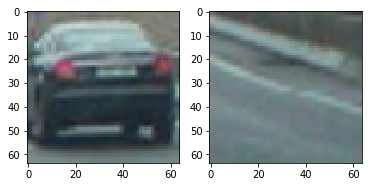

In [7]:
plt.subplot(121),plt.imshow(test_img)
plt.subplot(122),plt.imshow(mpimg.imread(nonvehicle_list[ran_idx]))

# Feature extraction
## HOG (Histogram of Oriented Gradients)

In [ ]:
hog_features, hog_image = get_hog_features(test_gray, orient=9, pix_per_cell=5, cell_per_block=2, vis=True)

fig1 = plt.figure(dpi=50)
plt.subplot(121),plt.imshow(test_gray, cmap='gray')
plt.subplot(122),plt.imshow(hog_image, cmap='gray')
fig1.tight_layout()
fig2 = plt.figure(dpi=50)
plt.plot(hog_features, ),fig2.tight_layout()

## Binned color

In [ ]:
fig = plt.figure(dpi=50)
plt.subplot(211),plt.imshow(test_img)
plt.subplot(212),plt.plot(bin_spatial(test_img))
fig.tight_layout()

## Color histogram

In [ ]:
fig = plt.figure(dpi=50)
plt.subplot(211), plt.imshow(test_img)
plt.subplot(212), plt.plot(color_hist(test_img)),plt.xticks([])
fig.tight_layout()

## Parameter choiced

In [8]:
# Parameter choised
color_space = 'YCrCb'   # Can be RGB, HSV, LUV, *HLS, YUV, YCrCb
orient = 32            #9 # HOG orientations
pix_per_cell = 16      #8 # HOG pixels per cell
cell_per_block = 2    #2 # HOG cells per block
hog_channel = 'ALL'   # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16)  #(8, 8) # Spatial binning dimensions
hist_bins =  16        #8 # Number of histogram bins
spatial_feat = False   # Spatial features on or off
hist_feat = False      # Histogram features on or off
hog_feat = True       # HOG features on or off

In [9]:
# Extract features from cars and non-cars
car_features = extract_features(vehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
# Dataset preprocessing, Normalization
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=ran_idx)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f18882020b8>,
 Text(0.5,1,'Starndardized'),
 ([], <a list of 0 Text xticklabel objects>))

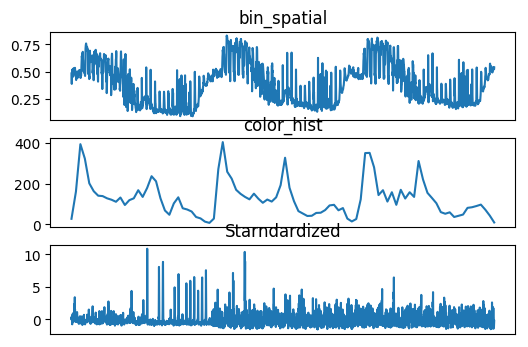

In [12]:
fig = plt.figure(dpi=100)
plt.subplot(311),plt.plot(bin_spatial(test_img)),plt.title('bin_spatial'),plt.xticks([])
plt.subplot(312),plt.plot(color_hist(test_img)),plt.title('color_hist'),plt.xticks([])
plt.subplot(313),plt.plot(X_train[ran_idx]),plt.title('Starndardized'),plt.xticks([])


# Classifier

In [13]:
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


1.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9672


In [14]:
print(svc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


# window search

## hog_subsample

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features).reshape(1,-1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)                
                bbox.append(box)
    return bbox, draw_img#, hog_features, spatial_features, hist_features

In [38]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = X_scaler.transform(hog_features.reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)                
                bbox.append(box)
    return bbox, draw_img#, hog_features, spatial_features, hist_features

In [39]:
ystart = 400
ystop = 656
scale = 1.5
test_img = mpimg.imread('./test_images/test1.jpg')
test_img = cv2.imread('./test_images/test1.jpg')

In [40]:
# find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
testbbox, draw_img = find_cars(img=test_img,
                               ystart=ystart,
                               ystop=ystop,
                               scale=scale,
                               svc=svc,
                               X_scaler=X_scaler,
                               orient=orient,
                               pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [41]:
testbbox

[[(0, 496), (96, 592)],
 [(48, 400), (144, 496)],
 [(96, 448), (192, 544)],
 [(144, 448), (240, 544)],
 [(192, 400), (288, 496)],
 [(192, 448), (288, 544)],
 [(240, 496), (336, 592)],
 [(336, 400), (432, 496)],
 [(336, 496), (432, 592)],
 [(384, 448), (480, 544)],
 [(384, 496), (480, 592)],
 [(480, 448), (576, 544)],
 [(528, 400), (624, 496)],
 [(576, 448), (672, 544)],
 [(768, 400), (864, 496)],
 [(816, 400), (912, 496)],
 [(864, 400), (960, 496)],
 [(960, 400), (1056, 496)],
 [(1056, 400), (1152, 496)],
 [(1056, 448), (1152, 544)],
 [(1104, 400), (1200, 496)],
 [(1104, 448), (1200, 544)]]

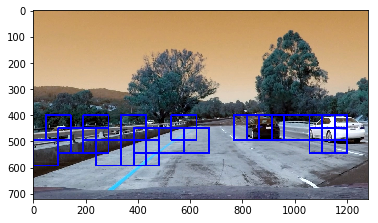

In [42]:
plt.imshow(draw_img)

In [49]:
def find_cars_multiple_scale(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #scales = [1.1, 1.4, 1.8, 2.4, 2.9, 3.4]
    scales = [0.5, 0.7, 1.1, 2.0]
    #scales = [1.0, 1.5, 2.0, 2.5, 2.9, 3.4]
    bbox_list = []
    bboxs = []           
    for scale in scales:
        #The first half of scales is valid for the upper half of image
        #box,draw_img, = find_cars(img, ystart,ystop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
        box, draw_img = find_cars(img=img,
                                   ystart=ystart,
                                   ystop=ystop,
                                   scale=scale,
                                   svc=svc,
                                   X_scaler=X_scaler,
                                   orient=orient,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins)
        bboxs.append(box)
        
    for i in range(len(bboxs)):
        for bbox in bboxs[i]:
            bbox_list.append(bbox)
            
    return bbox_list

In [50]:
out_bbox = find_cars_multiple_scale(test_img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
len(out_bbox), out_bbox

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(228,
 [[(0, 448), (32, 480)],
  [(0, 464), (32, 496)],
  [(32, 464), (64, 496)],
  [(48, 416), (80, 448)],
  [(64, 464), (96, 496)],
  [(80, 432), (112, 464)],
  [(80, 464), (112, 496)],
  [(96, 432), (128, 464)],
  [(112, 432), (144, 464)],
  [(112, 464), (144, 496)],
  [(128, 400), (160, 432)],
  [(128, 416), (160, 448)],
  [(128, 464), (160, 496)],
  [(128, 480), (160, 512)],
  [(128, 496), (160, 528)],
  [(144, 448), (176, 480)],
  [(144, 464), (176, 496)],
  [(144, 496), (176, 528)],
  [(160, 400), (192, 432)],
  [(160, 448), (192, 480)],
  [(176, 416), (208, 448)],
  [(176, 432), (208, 464)],
  [(208, 432), (240, 464)],
  [(208, 496), (240, 528)],
  [(224, 432), (256, 464)],
  [(224, 448), (256, 480)],
  [(224, 544), (256, 576)],
  [(240, 464), (272, 496)],
  [(272, 400), (304, 432)],
  [(288, 416), (320, 448)],
  [(288, 432), (320, 464)],
  [(304, 432), (336, 464)],
  [(320, 416), (352, 448)],
  [(320, 464), (352, 496)],
  [(336, 416), (368, 448)],
  [(336, 608), (368, 640)],
 

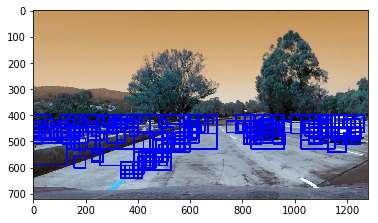

In [51]:
# Plot multi-scaled bounding-box
imcopy = np.copy(test_img)
for bbox in out_bbox:
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255),6)

plt.imshow(imcopy)

## Generate heat-map

In [52]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
        bbox_list.append(bbox)
    # Return the image
    return img, bbox_list

def get_heatmap(img ,box_list,threshold=1, showImg = True):
    draw_img = np.copy(img)
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list=box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img,lbl_heat = draw_labeled_bboxes(draw_img,labels)
    
    if showImg ==  True:
        return draw_img, heatmap, lbl_heat
    else:
        return heatmap, lbl_heat

[((288, 416), (334, 463)),
 ((806, 416), (916, 495)),
 ((1040, 416), (1125, 479)),
 ((358, 422), (379, 443)),
 ((80, 435), (175, 504)),
 ((201, 435), (207, 443)),
 ((336, 435), (350, 447)),
 ((582, 435), (625, 469)),
 ((0, 444), (65, 487)),
 ((940, 448), (943, 463)),
 ((67, 464), (69, 469)),
 ((320, 464), (334, 465)),
 ((336, 464), (350, 465)),
 ((464, 464), (580, 575)),
 ((1052, 467), (1054, 469)),
 ((592, 470), (597, 479)),
 ((1136, 470), (1140, 479)),
 ((403, 556), (468, 591)),
 ((387, 608), (399, 609))]

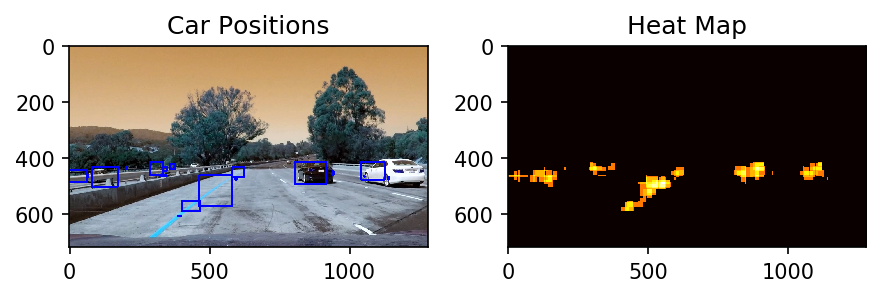

In [57]:
draw_img, heatmap, heatmap_bbox_list = get_heatmap(test_img, out_bbox, threshold=5)

fig = plt.figure(dpi=150)
plt.subplot(221)
plt.imshow(draw_img)
plt.title('Car Positions')

plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

fig.tight_layout()
heatmap_bbox_list

## Eliminate False Positives

In [58]:
n_frames = 20
smooth_thres = 10
smooth_average = 10
bbox_frames = []
counter = 0

for _ in range(n_frames):
    bbox_frames.append(0)

def process_image(img):
    global counter
    global bbox_frames
    
    counter +=1
    counterFrame = counter % n_frames
        
    # Find the multi-scaled bounding-box
    out_bbox = find_cars_multiple_scale(img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    
    # Generate the heatmap
    _, heatmap, heatmap_bbox_list = get_heatmap(img, out_bbox, threshold=smooth_thres)
    
    bbox_frames[counterFrame] = heatmap_bbox_list
    
    
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
                
    draw_img, heatmap, heatmap_bbox_list = get_heatmap(img, bbox2, threshold=smooth_average)
    
    return draw_img

In [59]:
n_frames = 10#20
smooth_thres = 5#10
smooth_average = 3#10
bbox_frames = []
counter = 0

for _ in range(n_frames):
    bbox_frames.append(0)

def process_image(img):
    global counter
    global bbox_frames
    

    counterFrame = counter % n_frames
        
    # Find the multi-scaled bounding-box
    out_bbox = find_cars_multiple_scale(img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    
    # Generate the heatmap
    _, heatmap, heatmap_bbox_list = get_heatmap(img, out_bbox, threshold=smooth_thres)
    
    if counter < n_frames:
        bbox_frames[counter] = heatmap_bbox_list
        
    else:
        bbox_frames.pop(0)
        bbox_frames.append(heatmap_bbox_list)
    
    #bbox_frames[counterFrame] = heatmap_bbox_list
    
    
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
                
    draw_img, heatmap, heatmap_bbox_list = get_heatmap(img, bbox2, threshold=smooth_average)
    
    counter +=1
    
    return draw_img

# Video results

In [60]:
from moviepy.editor import VideoFileClip
import time

In [61]:
output1 = 'out_test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
out_clip1 = clip1.fl_image(process_image)
%time out_clip1.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 97%|█████████▋| 38/39 [01:08<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 1min 8s, sys: 172 ms, total: 1min 9s
Wall time: 1min 9s


# Conclusion

In [62]:
output = 'out_project_video.mp4'
clip = VideoFileClip("./project_video.mp4").subclip(10,15)
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


 99%|█████████▉| 125/126 [03:47<00:01,  1.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 3min 46s, sys: 764 ms, total: 3min 47s
Wall time: 3min 48s


# Reference
* Udacity SDC nanodegree P4 lesson scripts.
* https://chatbotslife.com/vehicle-detection-and-tracking-using-computer-vision-baea4df65906